In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import multivariate_normal
from scipy.special import exp1,factorial
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib
import os
import glob
import json
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import binom,nbinom
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def get_lc(sigma,s):
    return np.sqrt(sigma**2/s)

def get_lambda_theory(w,rho,sigma,s):
    lc = get_lc(sigma,s)
    term = (w / lc) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (4*np.pi)/prod_term

def get_prob_seg(n,w,rho,sigma,s,mu):
    lc = get_lc(sigma,s)
    lam = get_lambda_theory(w,rho,sigma,s)
    theta = mu*rho*lc*lc*lam
    gamma = s*rho*lc*lc*lam
    return 1-(gamma/(gamma+n))**theta

def cumulative_maf(w, rho, sigma, s, mu, n,L=10000):
    allele_counts = np.arange(n)
    numsites = get_sfs_theory(allele_counts, n, mu, s, rho, sigma, w)*L  
    cumulative_prob = np.prod((1 - allele_counts / n)**numsites)
    return 1 - cumulative_prob

def get_prob_singletons(n,w,rho,sigma,s,mu):
    lc = get_lc(sigma,s)
    lam = get_lambda_theory(w,rho,sigma,s)
    theta = mu*rho*lc*lc*lam
    gamma = s*rho*lc*lc*lam
    return theta*(1-(gamma/(gamma+n)))*((gamma/(gamma+n))**theta)

def seg_allele_freq(n,w,rho,sigma,s,mu):
    pr_seg = get_prob_seg(n,w,rho,sigma,s,mu)
    return (mu/s)/pr_seg

def get_het(w,rho,sigma,s,mu):
    lc = get_lc(sigma,s)
    lam = get_lambda_theory(w,rho,sigma,s)
    theta = mu*rho*lc*lc*lam
    gamma = s*rho*lc*lc*lam
    return (2*theta/gamma)*(1-((1-theta)/gamma))

def get_prob_seg_unif(n,s,mu,N):
    gamma = s*N
    theta = mu*N
    return 1 - (gamma/(gamma+n))**theta

def get_prob_singletons_unif(n,s,mu,N):
    gamma = s*N
    theta = mu*N
    return theta*((gamma/(gamma+n))**theta)*(1-gamma/(gamma+n))

def seg_allele_freq_unif(n,s,mu,N):
    prob_seg = get_prob_seg_unif(n,s,mu,N)
    return (mu/s)/prob_seg

def get_het_unif(s,mu,N):
    gamma = s*N
    theta = mu*N
    return (2*theta/gamma)*(1-((1-theta)/gamma))

def get_EP_sim(ps, zeros):
    return np.sum(ps) / (len(ps) + zeros)

def get_EPsquared_sim(ps, zeros):
    return (np.sum(ps ** 2) / (len(ps) + zeros))

def get_lambda_sim(EP,EPsquared,sigma,s):
    lc = get_lc(sigma,s)
    return EP/(s*rho*lc*lc*(EPsquared-EP**2))

def load_data(file):
    with open(file, "r") as json_file:
        data = json.load(json_file)
    return data

def concatenate_data(files):
    combined_sampled_p = []
    combined_zero_samples = 0
    for f in files:
        data = load_data(f)
        combined_sampled_p.extend(data['sampled_p_flattened'])
        combined_zero_samples += data['zero_samples']
    return np.array(combined_sampled_p), combined_zero_samples

def sample_sfs(ps, zeros, n, max_allele_count=10):
    running_sfs = np.zeros(max_allele_count + 1)
    ps = np.where(ps > 1e-100, ps, 0.0)
    j = np.arange(max_allele_count)
    pmf_matrix = binom.pmf(j[:, np.newaxis], n, ps)
    running_sfs[:-1] = np.sum(pmf_matrix, axis=1)
    running_sfs[-1] = np.sum(binom.sf(max_allele_count - 1, n, ps))
    running_sfs[0] += zeros
    expected_sfs = running_sfs / np.sum(running_sfs)
    return expected_sfs

def get_EP_theory(mu, s):
    return mu / s

def get_EPsquared_theory(mu, s, rho, sigma, w):
    lcs = get_lc(sigma, s)**2
    term = (w / np.sqrt(lcs)) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (mu / (s ** 2 * rho * 4 * np.pi * lcs)) * prod_term + mu ** 2 / s ** 2

def get_sfs_theory(x,n,mu,s,rho,sigma,w):
    mean = get_EP_theory(mu,s)
    var = get_EPsquared_theory(mu,s,rho,sigma,w) - mean**2
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

def get_sfs_theory_unif(x,n,mu,s,N):
    mean = mu/s
    var = mu/(s*s*N)
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

In [6]:
colors_s = ['steelblue','orchid','darkorange']
colors_n = ['#F6C5F4', '#EFA2E8', '#DA70D6', '#B053A3']

In [7]:
plt.rcParams['axes.labelsize'] = 8    
plt.rcParams['axes.titlesize'] = 9    
plt.rcParams['xtick.labelsize'] = 8   
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['font.family']='Arial'

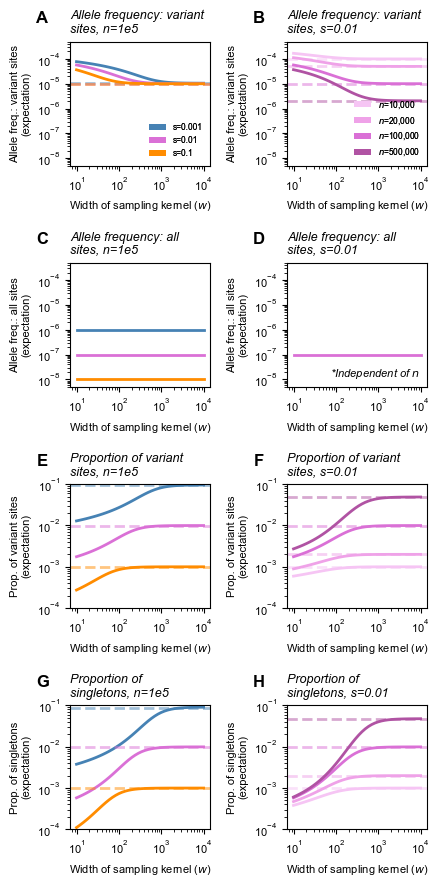

In [8]:
fig, axs = plt.subplots(4, 2, figsize=(4.49,9))

n_list = [10000,20000,100000,500000]
n_list_lab = [r"$n$=10,000","$n$=20,000","$n$=100,000","$n$=500,000"]
w_list = np.logspace(1,4,40)
sigma = 10
s = 0.01
mu = 1e-9
rho = 20
N = rho*rho*10000000
L = 1000
for i,n in enumerate(n_list):
    axs[2,1].axhline(get_prob_seg_unif(n,s,mu,N),color=colors_n[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[0,1].axhline(seg_allele_freq_unif(n,s,mu,N),color=colors_n[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[3,1].axhline(get_prob_singletons_unif(n,s,mu,N),color=colors_n[i],linewidth=2,linestyle='--',alpha=0.5)
    pr_seg_vec = [get_prob_seg(n,w,rho,sigma,s,mu) for w in w_list]
    freq_vec = [seg_allele_freq(n,w,rho,sigma,s,mu) for w in w_list]
    sing_vec = [get_prob_singletons(n,w,rho,sigma,s,mu) for w in w_list]
    axs[2,1].loglog(w_list,pr_seg_vec,color = colors_n[i],label=n_list_lab[i],linewidth=2,alpha=1)
    axs[0,1].loglog(w_list,freq_vec,color = colors_n[i],label=n_list_lab[i],linewidth=2,alpha=1)
    axs[3,1].loglog(w_list,sing_vec,color = colors_n[i],label=n_list_lab[i],linewidth=2,alpha=1)
    
freq_vec_2 = [get_EP_theory(mu,s) for w in w_list]
axs[1,1].plot(w_list,freq_vec_2,linewidth=2,alpha=1,color='orchid')


axs[2,1].set_ylim(1e-4,1e-1)
axs[2,1].set_xlabel(r"Width of sampling kernel ($w$)")
axs[2,1].set_ylabel("Prop. of variant sites\n(expectation)")
axs[2,1].set_title("Proportion of variant\nsites, s=0.01",fontstyle='italic',loc='left')

axs[0,1].set_ylim(5e-9,5e-4)
axs[0,1].set_xlabel(r"Width of sampling kernel ($w$)")
axs[0,1].set_ylabel("Allele freq.: variant sites\n(expectation)")
axs[0,1].set_title("Allele frequency: variant\nsites, s=0.01",fontstyle='italic',loc='left')

axs[3,1].set_xlabel(r"Width of sampling kernel ($w$)")
axs[3,1].set_ylabel("Prop. of singletons\n(expectation)")
axs[3,1].set_title("Proportion of\nsingletons, s=0.01",fontstyle='italic',loc='left')
axs[3,1].set_ylim(1e-4,1e-1)

axs[1,0].set_xlabel(r"Width of sampling kernel ($w$)")
axs[1,1].set_ylabel("Allele freq.: all sites\n(expectation)")
axs[1,1].set_title("Allele frequency: all\nsites, s=0.01",fontstyle='italic',loc='left')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].set_ylim(5e-9,5e-4)


elements = [Patch(facecolor=colors_n[0],edgecolor='None',label=f'{n_list_lab[0]}'),
            Patch(facecolor=colors_n[1],edgecolor='None',label=f'{n_list_lab[1]}'),
            Patch(facecolor=colors_n[2],edgecolor='None',label=f'{n_list_lab[2]}'),
            Patch(facecolor=colors_n[3],edgecolor='None',label=f'{n_list_lab[3]}')
            ]
leg1 = axs[0,1].legend(handles=elements,frameon=False,loc='lower right')
axs[0,1].add_artist(leg1)
# leg1 = axs[1,1].legend(handles=elements,frameon=False,loc='lower right')
# axs[1,1].add_artist(leg1)
# leg1 = axs[2,1].legend(handles=elements,frameon=False,loc='lower right')
# axs[2,1].add_artist(leg1)

axs[1,1].set_xlabel(r"Width of sampling kernel ($w$)")


n = 100000
s_list = [0.001,0.01,0.1]
s_list_lab = [r"$s$=0.001","$s$=0.01","$s$=0.1"]
lt=['-','dotted','-']
for i,s in enumerate(s_list):
    axs[2,0].axhline(get_prob_seg_unif(n,s,mu,N),color=colors_s[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[0,0].axhline(seg_allele_freq_unif(n,s,mu,N),color=colors_s[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[3,0].axhline(get_prob_singletons_unif(n,s,mu,N),color=colors_s[i],linewidth=2,linestyle='--',alpha=0.5)
    pr_seg_vec = [get_prob_seg(n,w,rho,sigma,s,mu) for w in w_list]
    freq_vec = [seg_allele_freq(n,w,rho,sigma,s,mu) for w in w_list]
    sing_vec = [get_prob_singletons(n,w,rho,sigma,s,mu) for w in w_list]
    axs[2,0].loglog(w_list,pr_seg_vec,color = colors_s[i],label=s_list_lab[i],linewidth=2,alpha=1)
    axs[0,0].loglog(w_list,freq_vec,color = colors_s[i],label=s_list_lab[i],linewidth=2,alpha=1)
    axs[3,0].loglog(w_list,sing_vec,color = colors_s[i],label=s_list_lab[i],linewidth=2,alpha=1)
    freq_vec_2 = [get_EP_theory(mu,s) for w in w_list]
    axs[1,0].plot(w_list,freq_vec_2,linewidth=2,alpha=1,color=colors_s[i],label=s_list_lab[i])


axs[2,0].set_ylim(1e-4,1e-1)
axs[2,0].set_xlabel(r"Width of sampling kernel ($w$)")
axs[2,0].set_ylabel("Prop. of variant sites\n(expectation)")
axs[2,0].set_title("Proportion of variant\nsites, n=1e5",fontstyle='italic',loc='left')

axs[0,0].set_ylim(5e-9,5e-4)
axs[0,0].set_xlabel(r"Width of sampling kernel ($w$)")
axs[0,0].set_ylabel("Allele freq.: variant sites\n(expectation)")
axs[0,0].set_title("Allele frequency: variant\nsites, n=1e5",fontstyle='italic',loc='left')

axs[3,0].set_xlabel(r"Width of sampling kernel ($w$)")
axs[3,0].set_ylabel("Prop. of singletons\n(expectation)")
axs[3,0].set_title("Proportion of\nsingletons, n=1e5",fontstyle='italic',loc='left')
axs[3,0].set_ylim(1e-4,1e-1)

axs[1,0].set_xlabel(r"Width of sampling kernel ($w$)")
axs[1,0].set_ylabel("Allele freq.: all sites\n(expectation)")
axs[1,0].set_title("Allele frequency: all\nsites, n=1e5",fontstyle='italic',loc='left')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_ylim(5e-9,5e-4)


elements = [Patch(facecolor=colors_s[0],edgecolor='None',label=f's={s_list[0]}'),
            Patch(facecolor=colors_s[1],edgecolor='None',label=f's={s_list[1]}'),
            Patch(facecolor=colors_s[2],edgecolor='None',label=f's={s_list[2]}')]
leg1 = axs[0,0].legend(handles=elements,frameon=False,loc='lower right')
axs[0,0].add_artist(leg1)
# leg1 = axs[1,0].legend(handles=elements,frameon=False,loc='lower right')
# axs[1,0].add_artist(leg1)
# leg1 = axs[2,0].legend(handles=elements,frameon=False,loc='lower right')
# axs[2,0].add_artist(leg1)
# leg1 = axs[3,0].legend(handles=elements,frameon=False,loc='upper right')
# axs[3,0].add_artist(leg1)


axs[0,0].text(-0.2,1.15, 'A', transform=axs[0,0].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[0,1].text(-0.2,1.15, 'B', transform=axs[0,1].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[1,0].text(-0.2,1.15, 'C', transform=axs[1,0].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[1,1].text(-0.2,1.15, 'D', transform=axs[1,1].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[2,0].text(-0.2,1.15, 'E', transform=axs[2,0].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[2,1].text(-0.2,1.15, 'F', transform=axs[2,1].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[3,0].text(-0.2,1.15, 'G', transform=axs[3,0].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[3,1].text(-0.2,1.15, 'H', transform=axs[3,1].transAxes, 
         fontsize=12, fontweight='bold', ha='center')

axs[1,1].text(0.95, 0.05, '*Independent of $n$', transform=axs[1,1].transAxes, 
              fontsize=8, fontstyle='italic', ha='right', va='bottom')


plt.tight_layout()
plt.savefig("sum_stats_v6_PNASformat.pdf")


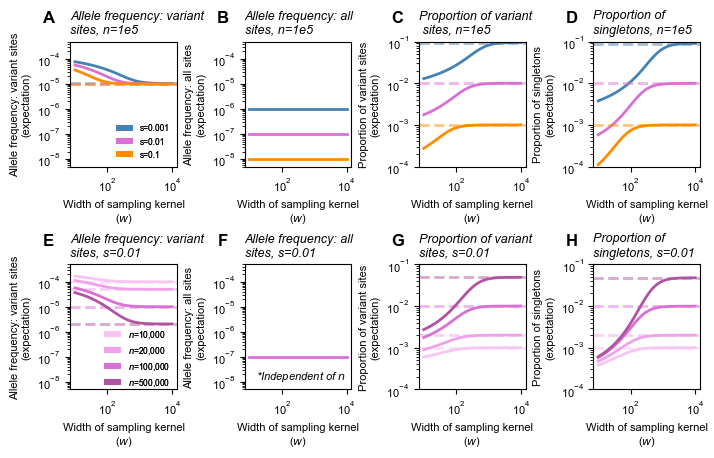

In [51]:
fig, axs = plt.subplots(2, 4, figsize=(7.01,4.49))

n_list = [10000,20000,100000,500000]
n_list_lab = [r"$n$=10,000","$n$=20,000","$n$=100,000","$n$=500,000"]
w_list = np.logspace(1,4,40)
sigma = 10
s = 0.01
mu = 1e-9
rho = 20
N = rho*rho*10000000
L = 1000
for i,n in enumerate(n_list):
    axs[1,2].axhline(get_prob_seg_unif(n,s,mu,N),color=colors_n[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[1,0].axhline(seg_allele_freq_unif(n,s,mu,N),color=colors_n[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[1,3].axhline(get_prob_singletons_unif(n,s,mu,N),color=colors_n[i],linewidth=2,linestyle='--',alpha=0.5)
    pr_seg_vec = [get_prob_seg(n,w,rho,sigma,s,mu) for w in w_list]
    freq_vec = [seg_allele_freq(n,w,rho,sigma,s,mu) for w in w_list]
    sing_vec = [get_prob_singletons(n,w,rho,sigma,s,mu) for w in w_list]
    axs[1,2].loglog(w_list,pr_seg_vec,color = colors_n[i],label=n_list_lab[i],linewidth=2,alpha=1)
    axs[1,0].loglog(w_list,freq_vec,color = colors_n[i],label=n_list_lab[i],linewidth=2,alpha=1)
    axs[1,3].loglog(w_list,sing_vec,color = colors_n[i],label=n_list_lab[i],linewidth=2,alpha=1)
    
freq_vec_2 = [get_EP_theory(mu,s) for w in w_list]
axs[1,1].plot(w_list,freq_vec_2,linewidth=2,alpha=1,color='orchid')


axs[1,2].set_ylim(1e-4,1e-1)
axs[1,2].set_xlabel("Width of sampling kernel\n($w$)")
axs[1,2].set_ylabel("Proportion of variant sites\n(expectation)")
axs[1,2].set_title("Proportion of variant\nsites, s=0.01",fontstyle='italic',loc='left')

axs[1,0].set_ylim(5e-9,5e-4)
axs[1,0].set_xlabel("Width of sampling kernel\n($w$)")
axs[1,0].set_ylabel("Allele frequency: variant sites\n(expectation)")
axs[1,0].set_title("Allele frequency: variant\nsites, s=0.01",fontstyle='italic',loc='left')

axs[1,3].set_xlabel("Width of sampling kernel\n($w$)")
axs[1,3].set_ylabel("Proportion of singletons\n(expectation)")
axs[1,3].set_title("Proportion of\nsingletons, s=0.01",fontstyle='italic',loc='left')
axs[1,3].set_ylim(1e-4,1e-1)

axs[1,1].set_xlabel("Width of sampling kernel\n($w$)")
axs[1,1].set_ylabel("Allele frequency: all sites\n(expectation)")
axs[1,1].set_title("Allele frequency: all\nsites, s=0.01",fontstyle='italic',loc='left')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].set_ylim(5e-9,5e-4)


elements = [Patch(facecolor=colors_n[0],edgecolor='None',label=f'{n_list_lab[0]}'),
            Patch(facecolor=colors_n[1],edgecolor='None',label=f'{n_list_lab[1]}'),
            Patch(facecolor=colors_n[2],edgecolor='None',label=f'{n_list_lab[2]}'),
            Patch(facecolor=colors_n[3],edgecolor='None',label=f'{n_list_lab[3]}')
            ]
leg1 = axs[1,0].legend(handles=elements, frameon=False, loc='lower right', bbox_to_anchor=(1, -0.05))


axs[1,0].add_artist(leg1)
# leg1 = axs[1,1].legend(handles=elements,frameon=False,loc='lower right')
# axs[1,1].add_artist(leg1)
# leg1 = axs[2,1].legend(handles=elements,frameon=False,loc='lower right')
# axs[2,1].add_artist(leg1)



n = 100000
s_list = [0.001,0.01,0.1]
s_list_lab = [r"$s$=0.001","$s$=0.01","$s$=0.1"]
lt=['-','dotted','-']
for i,s in enumerate(s_list):
    axs[0,2].axhline(get_prob_seg_unif(n,s,mu,N),color=colors_s[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[0,0].axhline(seg_allele_freq_unif(n,s,mu,N),color=colors_s[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[0,3].axhline(get_prob_singletons_unif(n,s,mu,N),color=colors_s[i],linewidth=2,linestyle='--',alpha=0.5)
    pr_seg_vec = [get_prob_seg(n,w,rho,sigma,s,mu) for w in w_list]
    freq_vec = [seg_allele_freq(n,w,rho,sigma,s,mu) for w in w_list]
    sing_vec = [get_prob_singletons(n,w,rho,sigma,s,mu) for w in w_list]
    axs[0,2].loglog(w_list,pr_seg_vec,color = colors_s[i],label=s_list_lab[i],linewidth=2,alpha=1)
    axs[0,0].loglog(w_list,freq_vec,color = colors_s[i],label=s_list_lab[i],linewidth=2,alpha=1)
    axs[0,3].loglog(w_list,sing_vec,color = colors_s[i],label=s_list_lab[i],linewidth=2,alpha=1)
    freq_vec_2 = [get_EP_theory(mu,s) for w in w_list]
    axs[0,1].plot(w_list,freq_vec_2,linewidth=2,alpha=1,color=colors_s[i],label=s_list_lab[i])


axs[0,2].set_ylim(1e-4,1e-1)
axs[0,2].set_xlabel("Width of sampling kernel\n($w$)")
axs[0,2].set_ylabel("Proportion of variant sites\n(expectation)")
axs[0,2].set_title("Proportion of variant\n sites, n=1e5",fontstyle='italic',loc='left')

axs[0,0].set_ylim(5e-9,5e-4)
axs[0,0].set_xlabel("Width of sampling kernel\n($w$)")
axs[0,0].set_ylabel("Allele frequency: variant sites\n(expectation)")
axs[0,0].set_title("Allele frequency: variant\nsites, n=1e5",fontstyle='italic',loc='left')

axs[0,3].set_xlabel("Width of sampling kernel\n($w$)")
axs[0,3].set_ylabel("Proportion of singletons\n(expectation)")
axs[0,3].set_title("Proportion of\nsingletons, n=1e5",fontstyle='italic',loc='left')
axs[0,3].set_ylim(1e-4,1e-1)

axs[0,1].set_xlabel("Width of sampling kernel\n($w$)")
axs[0,1].set_ylabel("Allele frequency: all sites\n(expectation)")
axs[0,1].set_title("Allele frequency: all\nsites, n=1e5",fontstyle='italic',loc='left')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_ylim(5e-9,5e-4)


elements = [Patch(facecolor=colors_s[0],edgecolor='None',label=f's={s_list[0]}'),
            Patch(facecolor=colors_s[1],edgecolor='None',label=f's={s_list[1]}'),
            Patch(facecolor=colors_s[2],edgecolor='None',label=f's={s_list[2]}')]
leg1 = axs[0,0].legend(handles=elements,frameon=False,loc='lower right')
axs[0,0].add_artist(leg1)
# leg1 = axs[1,0].legend(handles=elements,frameon=False,loc='lower right')
# axs[1,0].add_artist(leg1)
# leg1 = axs[2,0].legend(handles=elements,frameon=False,loc='lower right')
# axs[2,0].add_artist(leg1)
# leg1 = axs[3,0].legend(handles=elements,frameon=False,loc='upper right')
# axs[3,0].add_artist(leg1)


axs[0,0].text(-0.2,1.15, 'A', transform=axs[0,0].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[1,0].text(-0.2,1.15, 'E', transform=axs[1,0].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[0,1].text(-0.2,1.15, 'B', transform=axs[0,1].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[1,1].text(-0.2,1.15, 'F', transform=axs[1,1].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[0,2].text(-0.2,1.15, 'C', transform=axs[0,2].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[1,2].text(-0.2,1.15, 'G', transform=axs[1,2].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[0,3].text(-0.2,1.15, 'D', transform=axs[0,3].transAxes, 
         fontsize=12, fontweight='bold', ha='center')
axs[1,3].text(-0.2,1.15, 'H', transform=axs[1,3].transAxes, 
         fontsize=12, fontweight='bold', ha='center')

axs[1,1].text(0.95, 0.05, '*Independent of $n$', transform=axs[1,1].transAxes, 
              fontsize=8, fontstyle='italic', ha='right', va='bottom')


plt.tight_layout(pad=0.25)
plt.savefig("sum_stats_v6_PNASformat_horiz.pdf")


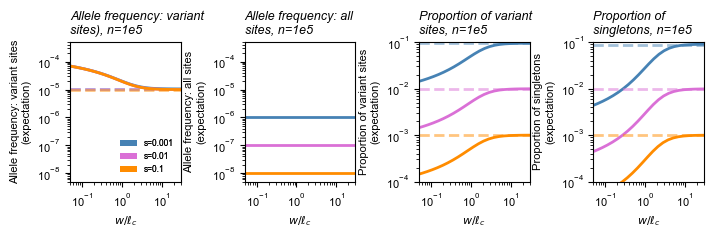

In [28]:
fig, axs = plt.subplots(1, 4, figsize=(7.01,2.25))

n_list = [10000,20000,100000,500000]
n_list_lab = [r"$n$=10,000","$n$=20,000","$n$=100,000","$n$=500,000"]
w_list = np.logspace(-1,4,40)
sigma = 10
s = 0.01
mu = 1e-9
rho = 20
N = rho*rho*10000000


n = 100000
s_list = [0.001,0.01,0.1]
s_list_lab = [r"$s$=0.001","$s$=0.01","$s$=0.1"]
scale = [1e-1,1,1e1]
for i,s in enumerate(s_list):
    lc = np.sqrt(sigma**2/s)
    axs[2].axhline(get_prob_seg_unif(n,s,mu,N),color=colors_s[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[0].axhline(seg_allele_freq_unif(n,s,mu,N),color=colors_s[i],linewidth=2,linestyle='--',alpha=0.5)
    axs[3].axhline(get_prob_singletons_unif(n,s,mu,N),color=colors_s[i],linewidth=2,linestyle='--',alpha=0.5)
    pr_seg_vec = [get_prob_seg(n,w,rho,sigma,s,mu) for w in w_list]
    freq_vec = [seg_allele_freq(n,w,rho,sigma,s,mu) for w in w_list]
    sing_vec = [get_prob_singletons(n,w,rho,sigma,s,mu) for w in w_list]
    axs[2].loglog(w_list/lc,pr_seg_vec,color = colors_s[i],label=s_list_lab[i],linewidth=2,alpha=1)
    axs[0].loglog(w_list/lc,freq_vec,color = colors_s[i],label=s_list_lab[i],linewidth=2,alpha=1)
    axs[3].loglog(w_list/lc,sing_vec,color = colors_s[i],label=s_list_lab[i],linewidth=2,alpha=1)
    freq_vec_2 = [get_EP_theory(mu,s) for w in w_list]
    axs[1].plot(w_list/lc,freq_vec_2,linewidth=2,alpha=1,color=colors_s[i],label=s_list_lab[i])

axs[2].set_ylim(1e-4,1e-1)
axs[2].set_xlabel(r"$w/\ell_c$")
axs[2].set_ylabel("Proportion of variant sites\n(expectation)")
axs[2].set_title("Proportion of variant\nsites, n=1e5",fontstyle='italic',loc='left')

# axs[1].legend(title=r'$n$',frameon=False,loc='upper left')
axs[0].set_ylim(5e-9,5e-4)
axs[0].set_xlabel(r"$w/\ell_c$")
axs[0].set_ylabel("Allele frequency: variant sites\n(expectation)")
axs[0].set_title("Allele frequency: variant\nsites), n=1e5",fontstyle='italic',loc='left')

axs[3].set_xlabel(r"$w/\ell_c$")
axs[3].set_ylabel("Proportion of singletons\n(expectation)")
axs[3].set_title("Proportion of\nsingletons, n=1e5",fontstyle='italic',loc='left')
axs[3].set_ylim(1e-4,1e-1)

axs[1].set_xlabel(r"$w/\ell_c$")
axs[1].set_ylabel("Allele frequency: all sites\n(expectation)")
axs[1].set_title("Allele frequency: all\nsites, n=1e5",fontstyle='italic',loc='left')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(5e-9,5e-4)


elements = [Patch(facecolor=colors_s[0],edgecolor='None',label=f's={s_list[0]}'),
            Patch(facecolor=colors_s[1],edgecolor='None',label=f's={s_list[1]}'),
            Patch(facecolor=colors_s[2],edgecolor='None',label=f's={s_list[2]}')]
# leg1 = axs[2].legend(handles=elements,frameon=False,loc='lower right')
# axs[2].add_artist(leg1)
# leg1 = axs[3].legend(handles=elements,frameon=False,loc='lower right')
# axs[3].add_artist(leg1)
leg1 = axs[0].legend(handles=elements,frameon=False,loc='lower right')
axs[0].add_artist(leg1)
# leg1 = axs[1].legend(handles=elements,frameon=False,loc='upper right')
# axs[1].add_artist(leg1)

axs[2].set_xlim(5e-2,3e1)
axs[0].set_xlim(5e-2,3e1)
axs[1].set_xlim(5e-2,3e1)
axs[3].set_xlim(5e-2,3e1)

plt.tight_layout(pad=0.25)
plt.savefig("sum_stats_scaled.pdf")


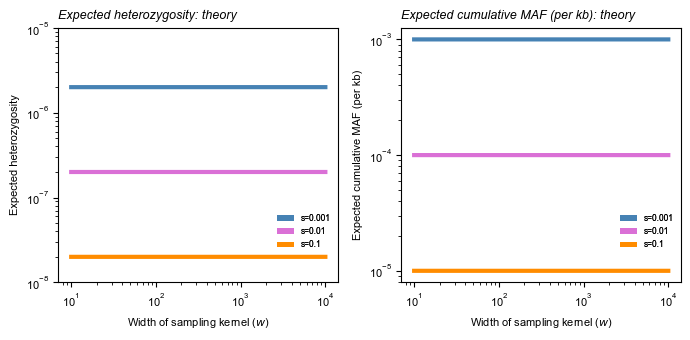

In [53]:

fig1, ax1 = plt.subplots(1, 2, figsize=(7.01, 3.5))  

# Expected Heterozygosity
for i, s in enumerate(s_list):
    het_vec = [get_het(w, rho, sigma, s, mu) for w in w_list]
    ax1[0].plot(w_list, het_vec, linewidth=3, alpha=1, color=colors_s[i], label=s_list_lab[i], linestyle='-')

elements = [Patch(facecolor=colors_s[0], edgecolor='None', label=f's={s_list[0]}'),
            Patch(facecolor=colors_s[1], edgecolor='None', label=f's={s_list[1]}'),
            Patch(facecolor=colors_s[2], edgecolor='None', label=f's={s_list[2]}')]
leg1 = ax1[0].legend(handles=elements, frameon=False, loc='lower right', bbox_to_anchor=(1, 0.1))
ax1[0].add_artist(leg1)

ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].set_ylim(1e-8, 1e-5)
ax1[0].set_xlabel(r'Width of sampling kernel ($w$)')
ax1[0].set_ylabel('Expected heterozygosity')
ax1[0].set_title('Expected heterozygosity: theory', loc='left', fontstyle='italic')

# Expected Cumulative MAF
for i, s in enumerate(s_list):
    cmaf_vec = [cumulative_maf(w, rho, sigma, s, mu, n, L=L) for w in w_list]
    ax1[1].plot(w_list, cmaf_vec, linewidth=3, alpha=1, color=colors_s[i], label=s_list_lab[i], linestyle='-')

leg2 = ax1[1].legend(handles=elements, frameon=False, loc='lower right', bbox_to_anchor=(1, 0.1))
ax1[1].add_artist(leg2)

ax1[1].set_xscale('log')
ax1[1].set_yscale('log')
# ax1[1].set_ylim(1e-4, 5e-2)
ax1[1].set_xlabel(r'Width of sampling kernel ($w$)')
ax1[1].set_ylabel('Expected cumulative MAF (per kb)')
ax1[1].set_title('Expected cumulative MAF (per kb): theory', loc='left', fontstyle='italic')

plt.tight_layout()
plt.savefig('cmaf_het_theory.pdf')


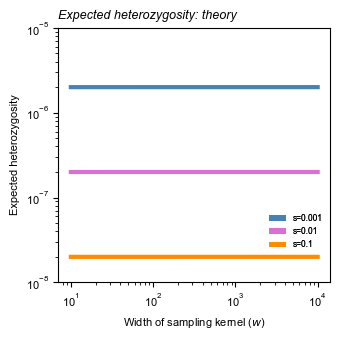

In [10]:

fig1, ax1 = plt.subplots(1, 1, figsize=(3.5, 3.5))  

# Expected Heterozygosity
for i, s in enumerate(s_list):
    het_vec = [get_het(w, rho, sigma, s, mu) for w in w_list]
    ax1.plot(w_list, het_vec, linewidth=3, alpha=1, color=colors_s[i], label=s_list_lab[i], linestyle='-')

elements = [Patch(facecolor=colors_s[0], edgecolor='None', label=f's={s_list[0]}'),
            Patch(facecolor=colors_s[1], edgecolor='None', label=f's={s_list[1]}'),
            Patch(facecolor=colors_s[2], edgecolor='None', label=f's={s_list[2]}')]
leg1 = ax1.legend(handles=elements, frameon=False, loc='lower right', bbox_to_anchor=(1, 0.1))
ax1.add_artist(leg1)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1e-8, 1e-5)
ax1.set_xlabel(r'Width of sampling kernel ($w$)')
ax1.set_ylabel('Expected heterozygosity')
ax1.set_title('Expected heterozygosity: theory', loc='left', fontstyle='italic')

plt.tight_layout()
plt.savefig('het_theory.pdf')
